In [14]:
# %load_ext autoreload
# %autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('./ml-fairness-gym'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environments import infectious_disease as id
from experiments import infectious_disease as ide
from agents import infectious_disease_agents as ida

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook"])
# plt.style.use("default")

Params(transition_matrix=array([[0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.01],
       [0.  , 0.  , 1.  ]]), treatment_transition_matrix=array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]]), state_names=['susceptible', 'infected', 'recovered'], healthy_index=0, infectious_index=1, healthy_exit_index=1, infection_probability=0.25, population_graph=<networkx.classes.graph.Graph object at 0x7f05190ec160>, initial_health_state=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], initial_health_state_seed=27, num_treatments=1, max_treatments=1, burn_in=0)


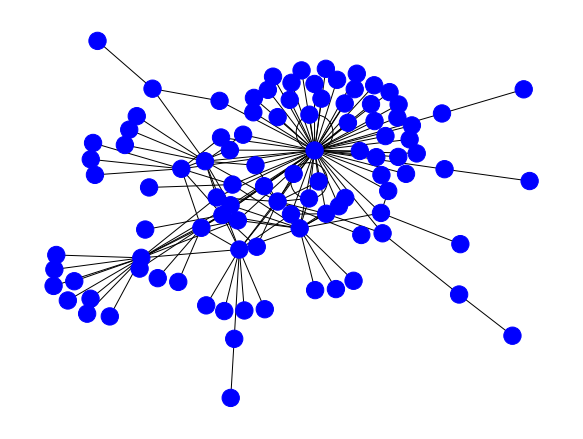

In [15]:
np.random.seed(13)

TAU   = 0.25
RHO   = 0.01
# ide.GRAPHS["scale"] = nx.generators.random_internet_as_graph(100)
ide.GRAPHS["scale"] = nx.Graph(nx.generators.scale_free_graph(100).to_undirected())

EXP = ide.Experiment()
EXP.graph_name = "scale"
EXP.infection_probability     = TAU
EXP.infected_exit_probability = RHO
EXP.num_treatments = 1
EXP.burn_in = 0
EXP.agent_constructor = ide.RandomAgent
EXP.scenario_builder()
print(EXP.env.initial_params)

positions = nx.spring_layout(EXP.env.initial_params.population_graph, seed=13)
color_map = ["blue", "red", "purple"]
EXP.env.render(color_map, pos=positions)

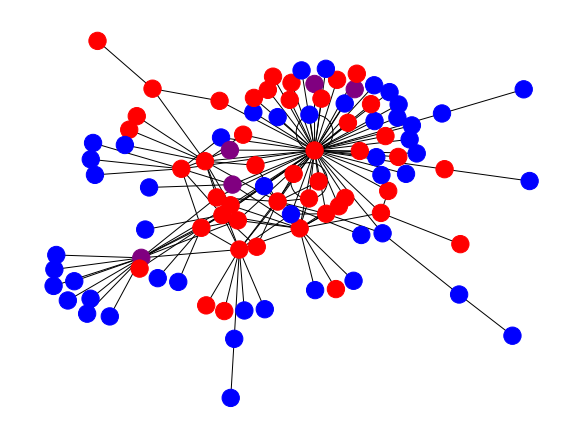

In [16]:
EXP.num_steps = 5
results = EXP.run()["metric_results"]
states = np.array(results["states"])
sick_days = np.array(results["sick-days"])

EXP.env.render(color_map, pos=positions)

In [17]:
from tqdm import trange

def _num_sickdays(states):
    n = np.zeros(states.shape[1], dtype=int)
    for i in range(states.shape[1]):
        col = states[:, i]
        n[i] = np.count_nonzero(col == 1)
    return n

def process_metrics(i, metrics, results):
    states = np.array(results["states"])
    num_sickdays = _num_sickdays(states)
    total_sickdays = np.sum(num_sickdays)
    metrics["num_sickdays"] += num_sickdays
    metrics["total_sickdays"] += total_sickdays

def run_simulations(n_sims, exp):
    size = ide.GRAPHS[exp.graph_name].number_of_nodes()
    metrics = {
        "num_sickdays": np.zeros(size),
        "total_sickdays": 0
    }

    exp.scenario_builder()
    for i in trange(n_sims):
        exp.seed = i
        # np.random.seed(i)
        r = exp.run()
        process_metrics(i, metrics, r["metric_results"])
    return metrics

In [18]:
EXP.num_steps = 20
N = 50

EXP.agent_constructor = ide.NullAgent
null_metrics = run_simulations(N, EXP)


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


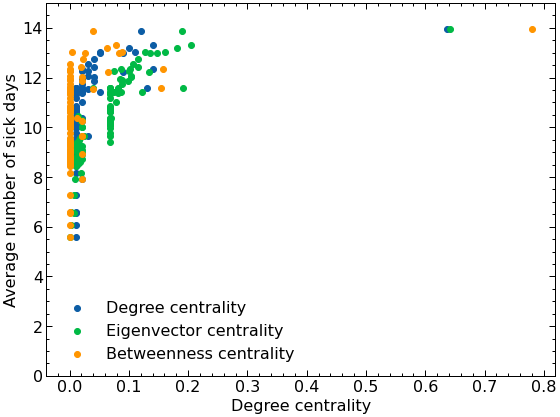

In [22]:
metrics = [null_metrics]

G = ide.GRAPHS["scale"]
deg_cent = nx.centrality.degree_centrality(G).values()
eig_cent = nx.centrality.eigenvector_centrality(G).values()
btw_cent = nx.centrality.betweenness_centrality(G).values()

plt.figure()
plt.xlabel("Degree centrality")
plt.ylabel("Average number of sick days")
plt.ylim(bottom=0, top=15)
# plt.xlim(left=0.0, right=0.5)
for metric in metrics:
    num_sickdays = metric["num_sickdays"] / N
    plt.scatter(deg_cent, num_sickdays, label="Degree centrality")
    plt.scatter(eig_cent, num_sickdays, label="Eigenvector centrality")
    plt.scatter(btw_cent, num_sickdays, label="Betweenness centrality")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("out/chain-probinfect.png")